In [1]:
%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))
import numpy as np; np.set_printoptions(linewidth=110);
import pandas as pd
# tell pandas to show all columns when we display a DataFrame
pd.set_option("display.max_columns", None)

# first we need a bit of import boilerplate
import os
import sys
from sys import platform
if platform == 'win32':
    sys.path.append('D:/Brain_Network/Code/')
    manifest_path = 'D:/Brain_Network/Data/Allen_Institute_Dataset/manifest.json'
    project_dir = 'D:/Brain_Network/'
    num_paral_jobs = 8
elif platform =='darwin':
    sys.path.append('/Users/chenyu/Workspace/Brain_Network/Code/')
    manifest_path = '/Users/chenyu/Workspace/Brain_Network/Data/Allen_Institute_Dataset/manifest.json'
    project_dir = '/Users/chenyu/Workspace/Brain_Network/'
elif platform == 'linux':
    sys.path.append('/home/yuchen/workspace/Brain_Network/Code/')
    manifest_path = '/home/yuchen/workspace/Brain_Network/Data/Allen_Institute_Dataset/manifest.json'
    project_dir = '/home/yuchen/workspace/Brain_Network/'
    num_paral_jobs = 12
else:
    print('Add new computer system settings.')

import matplotlib.pyplot as plt
import networkx as nx
import seaborn
import scipy
import scipy.io as sio
from scipy.ndimage.filters import gaussian_filter
import seaborn
from tqdm import tqdm
from tqdm.notebook import trange
import time
import joblib
from joblib import Parallel, delayed

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache
from allensdk.brain_observatory.ecephys.ecephys_session import EcephysSession

import data_visualizer
import data_model
import fine_time_coupling_model
import smoothing_spline
import util
import hierarchical_sampling_model
import hierarchical_model_generator
import jitter


In [2]:
import allensdk
import pandas
import h5py
import pynwb
import hdmf
import matplotlib
print('allensdk', allensdk.__version__)
print('pandas', pandas.__version__)
print('h5py', h5py.__version__)
print('pynwb', pynwb.__version__)
print('hdmf', hdmf.__version__)
print('matplotlib', matplotlib.__version__)

allensdk 2.3.1
pandas 1.2.4
h5py 2.10.0
pynwb 1.4.0
hdmf 2.2.0
matplotlib 3.4.2


# Neuropixels data.

In [3]:
cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)

Donload time: 288000


In [4]:
session_id = 798911424  #  791319847 798911424  799864342
session = cache.get_session_data(session_id)

In [5]:
probes = ['probeC', 'probeD', 'probeE'] # ['probeC', 'probeE']
selected_units = session.units[
    session.units['ecephys_structure_acronym'].isin(util.VISUAL_AREA) &
    session.units['probe_description'].isin(probes)]
display(selected_units['probe_description'].value_counts())
display(selected_units['probe_description'].count())

probeC    94
probeE    89
probeD    78
Name: probe_description, dtype: int64

261

#### Fine Time Coupling Model

In [6]:
model = fine_time_coupling_model.FineTimeCouplingModel(session)

#### Trials Selection

In [10]:
# condition_ids = [275, 246, 268, 270, 284, 274, 249, 263, 265, 261, 286, 258, 278, 267, 280, 256, 260, 257, 281]
condition_ids = [247, 248, 250, 251, 252, 253, 254, 255, 259, 262, 264, 266, 269, 271, 272, 276, 277, 279, 282, 283, 285]
stimulus_table = session.get_stimulus_table(['drifting_gratings'])
trials_df = stimulus_table[stimulus_table['stimulus_condition_id'].isin(condition_ids)]
all_trials_indices = trials_df.index.values
trials_groups = trials_df.groupby('stimulus_condition_id')
all_condition_ids = list(trials_groups.groups.keys())
model.print_conditions(trials_groups)

0  247 temp freq [2.0] orient [180.0] contrast [0.8] [ 3799  3827  3847  3874  3883  3887  3908  3939 31059 31111 31115 49278 49348 49387 49396]
1  248 temp freq [1.0] orient [45.0] contrast [0.8] [ 3800  3807  3820  3853  3907  3975  3993 31013 31036 31091 31106 31120 31127 49216 49397]
2  250 temp freq [2.0] orient [270.0] contrast [0.8] [ 3802  3903  3991 31006 31109 31136 49229 49267 49273 49300 49308 49363 49369 49379 49382]
3  251 temp freq [1.0] orient [90.0] contrast [0.8] [ 3803  3806  3885  3890  3983 31017 31052 31131 31132 49224 49334 49345 49351 49373 49384]
4  252 temp freq [1.0] orient [0.0] contrast [0.8] [ 3804  3869  3873  3916 31037 31050 31061 31157 31193 49271 49279 49309 49404 49417 49429]
5  253 temp freq [1.0] orient [315.0] contrast [0.8] [ 3805  3812  3843  3850  3857  3952  3994 31008 31029 31163 31181 49269 49289 49338 49419]
6  254 temp freq [15.0] orient [180.0] contrast [0.8] [ 3808  3837  3856  3858  3879 31011 31019 31049 31118 31155 49208 49244 49291 4

## Spike Trains

In [8]:
trial_window = [0.4, 2.0]
spike_times = model.get_trial_metric_per_unit_per_trial(
        stimulus_presentation_ids=all_trials_indices,
        unit_ids=selected_units.index.values,
        trial_time_window=trial_window,
        metric_type='spike_times')


In [11]:
# display(spike_trains.shape)
# display(spike_trains.iloc[0,0].shape)
display(spike_times.shape)
# display(spike_times.head())

(261, 315)

# Trial-wise cluster, joint-trial filter fit.

In [12]:
model = fine_time_coupling_model.FineTimeCouplingModel(session)
model.initial_step(None, spike_times, selected_units, trials_groups, trial_window,
                   probes=['probeC', 'probeD', 'probeE'], num_areas=3, verbose=False)

conditions: [(0, 247), (1, 248), (2, 250), (3, 251), (4, 252), (5, 253), (6, 254), (7, 255), (8, 259), (9, 262), (10, 264), (11, 266), (12, 269), (13, 271), (14, 272), (15, 276), (16, 277), (17, 279), (18, 282), (19, 283), (20, 285)]


In [13]:
# select_condition_ids = [275, 246, 268, 270, 284, 274, 249, 263, 265, 261, 286, 258, 278, 267, 280, 256, 260, 257, 281]
select_condition_ids = [247, 248, 250, 251, 252, 253, 254, 255, 259, 262, 264, 266, 269, 271, 272, 276, 277, 279, 282, 283, 285]
stimulus_table = session.get_stimulus_table(['drifting_gratings'])
trials_df = stimulus_table[stimulus_table['stimulus_condition_id'].isin(select_condition_ids)]
selected_trial_ids = trials_df.index.values
print(selected_trial_ids)

[ 3799  3800  3802  3803  3804  3805  3806  3807  3808  3809  3812  3815  3818  3820  3821  3823  3825  3827
  3830  3832  3834  3836  3837  3838  3839  3840  3842  3843  3846  3847  3849  3850  3851  3853  3856  3857
  3858  3861  3863  3864  3865  3867  3868  3869  3871  3873  3874  3877  3879  3883  3885  3887  3890  3891
  3893  3896  3901  3902  3903  3907  3908  3909  3910  3913  3915  3916  3918  3919  3926  3927  3929  3931
  3935  3939  3940  3941  3945  3950  3952  3954  3957  3961  3963  3965  3969  3970  3971  3972  3974  3975
  3977  3978  3982  3983  3985  3990  3991  3993  3994 31001 31005 31006 31008 31009 31010 31011 31012 31013
 31017 31018 31019 31023 31025 31029 31032 31036 31037 31038 31041 31042 31044 31045 31049 31050 31052 31057
 31059 31060 31061 31063 31065 31067 31068 31069 31070 31073 31074 31082 31083 31084 31087 31088 31090 31091
 31094 31095 31097 31099 31100 31101 31102 31103 31106 31107 31109 31110 31111 31113 31115 31117 31118 31119
 31120 31121 31122 

/home/yuchen/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/yuchen/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/yuchen/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or

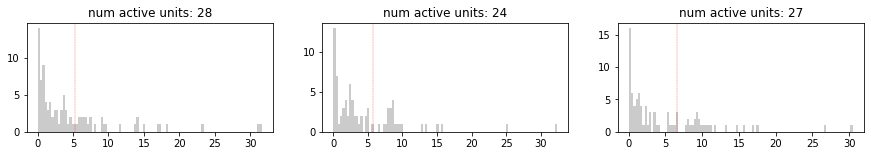

num_pairs: 672
num_pairs: 648
filter_membership.shape (672, 315)
membership cnt [(0, 211680)]
filter_membership.shape (648, 315)
membership cnt [(0, 204120)]
filter_membership.shape (1320, 315)
membership cnt [(0, 415800)]


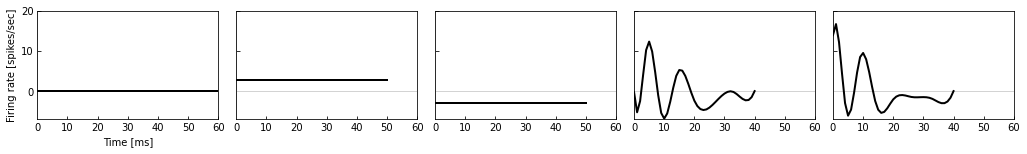

In [17]:
active_firing_rate_quantile_threshold = 0.7
active_units = model.get_active_units(active_firing_rate_quantile_threshold, group_type='probe', verbose=True)

probe_pairs = [('probeC', 'probeD')]
neuron_pairs = model.construct_unit_pairs(active_units, pair_type='between_probe', probe_pairs=probe_pairs, verbose=True)
filter_membership_CD = model.init_filter_membership(neuron_pairs, trial_ids=selected_trial_ids)

probe_pairs = [('probeD', 'probeE')]
neuron_pairs = model.construct_unit_pairs(active_units, pair_type='between_probe', probe_pairs=probe_pairs, verbose=True)
filter_membership_DE = model.init_filter_membership(neuron_pairs, trial_ids=selected_trial_ids)

# file_path = project_dir + 'Output/jitter/coupling_filter/CD_DE_condition19_joint_fit2/filter_membership_CD_itr149_20210523-070711.pkl'
# filter_membership_CD = util.load_variable(file_path)
# file_path = project_dir + 'Output/jitter/coupling_filter/CD_DE_condition19_joint_fit2/filter_membership_DE_itr149_20210523-070711.pkl'
# filter_membership_DE = util.load_variable(file_path)
filter_membership_joint = filter_membership_CD.append(filter_membership_DE)
model.filter_membership_statistics(filter_membership_CD, verbose=True)
model.filter_membership_statistics(filter_membership_DE, verbose=True)
model.filter_membership_statistics(filter_membership_joint, verbose=True)
group_portion = np.array([0.2, 0.2, 0.2, 0.2, 0.2])

file_path = project_dir + 'Output/jitter/coupling_filter/CD_DE_condition19_joint_fit2/group_model_pars_joint_itr149_20210523-071613.pkl'
group_model_pars = util.load_variable(file_path)
group_model_pars[2]['beta'][2] = -3  # TMP manual modification.
model.plot_multiple_filters(group_model_pars, ylim=[-7, 20], num_rows_cols=[1,5])

#### Estimate optimal kernel width (plug-in estimator)

#all trials:415800	#batch trials:1000
optimal kernel width  55.0


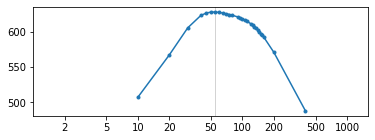

In [22]:
model.estimate_nuisance_kernel_width_together(filter_membership_joint, batch_size=1000)

### Parallel programming.

[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   34.5s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  3.1min
[Parallel(n_jobs=12)]: Done 285 out of 285 | elapsed:  5.0min finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   36.3s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  3.4min
[Parallel(n_jobs=12)]: Done 285 out of 285 | elapsed:  5.4min finished


filter_membership.shape (672, 285)
membership cnt [(0.0, 39394), (3.0, 36368), (2.0, 46866), (1.0, 39337), (4.0, 29555)]
filter_membership.shape (648, 285)
membership cnt [(0.0, 29952), (3.0, 36888), (2.0, 47326), (1.0, 38129), (4.0, 32385)]
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_kernel100ms_11252021_2242/filter_membership_CD_itr0_20211126_035336.pkl
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_kernel100ms_11252021_2242/filter_membership_DE_itr0_20211126_035336.pkl
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_kernel100ms_11252021_2242/group_portion_itr0_20211126_035336.pkl
filter_membership.shape (1320, 285)
#all trials:77466	#batch trials:77466
X.shape (1462336, 3), basis_int

/home/yuchen/workspace/Brain_Network/Code/jitter.py:4090: UserWarning: Reach max itrs 60. Last err:1.636e-02
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


#all trials:61940	#batch trials:61940
X.shape (1423041, 11), basis_integral.shape (11, 1),beta.shape(11, 1)
100%|███████████████████████████████████████████████████████████████| 60/60 [00:11<00:00,  5.15it/s]
num itr 59 [[-2403663.75302692]] 0.025783712689504953
beta [ 14.08344913   0.0342707   14.13741515  25.15788117 -24.30963566  23.17699885 -10.88146726   1.40730429
  -1.66235605  -0.20961789  -4.35963761]
gradient [-7.92087617e-01  9.93516045e+01 -2.44692967e+00 -2.25598098e+00 -8.50242053e-03 -2.18865409e+00
  1.08939558e+00  2.39336939e+00  1.71334896e+00  1.69934860e+00  1.46485182e+00]
Finish 4.


/home/yuchen/workspace/Brain_Network/Code/jitter.py:4090: UserWarning: Reach max itrs 60. Last err:2.578e-02
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


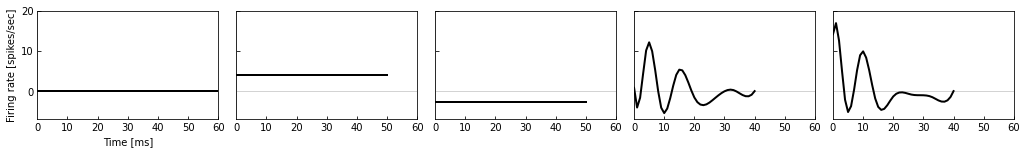

util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_kernel100ms_11252021_2242/group_model_pars_joint_itr0_20211126_041050.pkl


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   33.8s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  3.0min
[Parallel(n_jobs=12)]: Done 285 out of 285 | elapsed:  5.0min finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   36.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  3.4min
[Parallel(n_jobs=12)]: Done 285 out of 285 | elapsed:  5.4min finished


filter_membership.shape (672, 285)
membership cnt [(0.0, 43973), (3.0, 30076), (2.0, 48118), (1.0, 40798), (4.0, 28555)]
filter_membership.shape (648, 285)
membership cnt [(0.0, 33820), (3.0, 32187), (2.0, 49314), (1.0, 38090), (4.0, 31269)]
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_kernel100ms_11252021_2242/filter_membership_CD_itr1_20211126_042112.pkl
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_kernel100ms_11252021_2242/filter_membership_DE_itr1_20211126_042112.pkl
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_kernel100ms_11252021_2242/group_portion_itr1_20211126_042112.pkl
filter_membership.shape (1320, 285)
#all trials:78888	#batch trials:78888
X.shape (1424481, 3), basis_int

/home/yuchen/workspace/Brain_Network/Code/jitter.py:4090: UserWarning: Reach max itrs 60. Last err:1.809e-02
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


#all trials:59824	#batch trials:59824
X.shape (1378563, 11), basis_integral.shape (11, 1),beta.shape(11, 1)
100%|███████████████████████████████████████████████████████████████| 60/60 [00:11<00:00,  5.30it/s]
num itr 59 [[-2334040.33673097]] 0.024254886376840264
beta [ 13.96555144   0.03633884  14.84570266  25.19399435 -23.35643776  22.99463516 -10.17055731   2.00483509
  -1.2994462   -0.04866176  -4.26585232]
gradient [-1.92577821e+00  7.47517287e+00 -2.44619804e+00 -2.55715220e+00 -9.64160198e-01 -2.81977306e+00
 -9.46720827e-01  1.34806331e-01 -1.79769029e-03  4.35864246e-01  6.16292705e-01]
Finish 4.


/home/yuchen/workspace/Brain_Network/Code/jitter.py:4090: UserWarning: Reach max itrs 60. Last err:2.425e-02
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


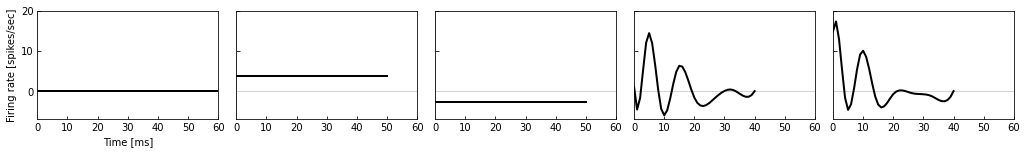

util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_kernel100ms_11252021_2242/group_model_pars_joint_itr1_20211126_043741.pkl


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   33.6s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  3.0min
[Parallel(n_jobs=12)]: Done 285 out of 285 | elapsed:  5.0min finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   36.2s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  3.3min
[Parallel(n_jobs=12)]: Done 285 out of 285 | elapsed:  5.4min finished


filter_membership.shape (672, 285)
membership cnt [(0.0, 44140), (3.0, 30291), (2.0, 49239), (1.0, 39850), (4.0, 28000)]
filter_membership.shape (648, 285)
membership cnt [(0.0, 33762), (3.0, 32265), (2.0, 50264), (1.0, 37369), (4.0, 31020)]
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_kernel100ms_11252021_2242/filter_membership_CD_itr2_20211126_044803.pkl
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_kernel100ms_11252021_2242/filter_membership_DE_itr2_20211126_044803.pkl
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_kernel100ms_11252021_2242/group_portion_itr2_20211126_044803.pkl
filter_membership.shape (1320, 285)
#all trials:77219	#batch trials:77219
X.shape (1383813, 3), basis_int

/home/yuchen/workspace/Brain_Network/Code/jitter.py:4090: UserWarning: Reach max itrs 60. Last err:2.428e-02
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


#all trials:59020	#batch trials:59020
X.shape (1375752, 11), basis_integral.shape (11, 1),beta.shape(11, 1)
100%|███████████████████████████████████████████████████████████████| 60/60 [00:11<00:00,  5.33it/s]
num itr 59 [[-2346289.71969549]] 0.02588944731426006
beta [ 14.07397683   0.03609522  15.60421821  26.69153    -24.37948005  24.11804341 -10.60763079   2.39168337
  -1.18422532  -0.11804508  -4.55697652]
gradient [-1.18375259 25.42238652 -2.51189486 -2.54571653 -0.70847288 -2.7039014  -0.29898867  0.77041062  0.48504835
  0.87508184  0.94212583]
Finish 4.


/home/yuchen/workspace/Brain_Network/Code/jitter.py:4090: UserWarning: Reach max itrs 60. Last err:2.589e-02
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


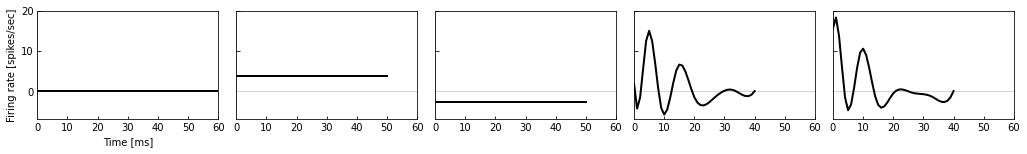

util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_kernel100ms_11252021_2242/group_model_pars_joint_itr2_20211126_050438.pkl


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   34.1s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  3.1min
[Parallel(n_jobs=12)]: Done 285 out of 285 | elapsed:  5.0min finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   36.7s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  3.4min
[Parallel(n_jobs=12)]: Done 285 out of 285 | elapsed:  5.4min finished


filter_membership.shape (672, 285)
membership cnt [(0.0, 44534), (3.0, 29771), (2.0, 49769), (1.0, 39572), (4.0, 27874)]
filter_membership.shape (648, 285)
membership cnt [(0.0, 34295), (3.0, 31819), (2.0, 50939), (1.0, 36866), (4.0, 30761)]
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_kernel100ms_11252021_2242/filter_membership_CD_itr3_20211126_051501.pkl
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_kernel100ms_11252021_2242/filter_membership_DE_itr3_20211126_051501.pkl
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_kernel100ms_11252021_2242/group_portion_itr3_20211126_051501.pkl
filter_membership.shape (1320, 285)
#all trials:76438	#batch trials:76438
X.shape (1368137, 3), basis_int

/home/yuchen/workspace/Brain_Network/Code/jitter.py:4090: UserWarning: Reach max itrs 60. Last err:2.559e-02
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


#all trials:58635	#batch trials:58635
X.shape (1360695, 11), basis_integral.shape (11, 1),beta.shape(11, 1)
100%|███████████████████████████████████████████████████████████████| 60/60 [00:11<00:00,  5.38it/s]
num itr 59 [[-2314767.55854695]] 0.026033801717229077
beta [ 13.97619948   0.02770579  15.44631678  27.0377866  -24.40632114  24.23601067 -10.63278458   2.70979087
  -1.05552376  -0.16422987  -4.65804077]
gradient [-1.22771307 33.17376193 -2.49370277 -2.55133106 -0.70083311 -2.67331425 -0.28361679  0.72770636  0.47439808
  0.93100608  0.9979353 ]
Finish 4.


/home/yuchen/workspace/Brain_Network/Code/jitter.py:4090: UserWarning: Reach max itrs 60. Last err:2.603e-02
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


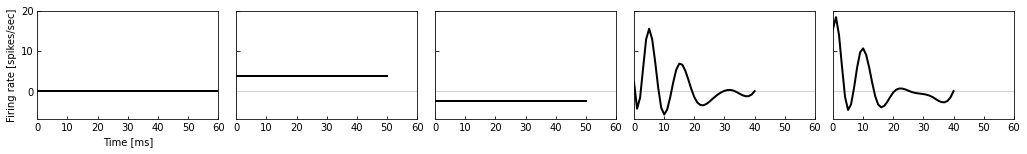

util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_kernel100ms_11252021_2242/group_model_pars_joint_itr3_20211126_053134.pkl


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   34.1s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  3.0min
[Parallel(n_jobs=12)]: Done 285 out of 285 | elapsed:  5.0min finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   36.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  3.4min
[Parallel(n_jobs=12)]: Done 285 out of 285 | elapsed:  5.4min finished


filter_membership.shape (672, 285)
membership cnt [(0.0, 44285), (3.0, 29778), (2.0, 49670), (1.0, 39831), (4.0, 27956)]
filter_membership.shape (648, 285)
membership cnt [(0.0, 33845), (3.0, 31907), (2.0, 51069), (1.0, 36935), (4.0, 30924)]
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_kernel100ms_11252021_2242/filter_membership_CD_itr4_20211126_054158.pkl
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_kernel100ms_11252021_2242/filter_membership_DE_itr4_20211126_054158.pkl
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_kernel100ms_11252021_2242/group_portion_itr4_20211126_054158.pkl
filter_membership.shape (1320, 285)
#all trials:76766	#batch trials:76766
X.shape (1363846, 3), basis_int

/home/yuchen/workspace/Brain_Network/Code/jitter.py:4090: UserWarning: Reach max itrs 60. Last err:2.499e-02
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


#all trials:58880	#batch trials:58880
X.shape (1366641, 11), basis_integral.shape (11, 1),beta.shape(11, 1)
100%|███████████████████████████████████████████████████████████████| 60/60 [00:11<00:00,  5.31it/s]
num itr 59 [[-2325206.06814166]] 0.025917204780020735
beta [ 1.39749639e+01  2.71245599e-02  1.52677987e+01  2.73508587e+01 -2.45914838e+01  2.43306814e+01
 -1.07647088e+01  2.93191635e+00 -1.00813901e+00 -2.16987604e-01 -4.79947429e+00]
gradient [-1.18649335 35.24668252 -2.49586496 -2.56916255 -0.67787434 -2.65077592 -0.23750107  0.7256354   0.4775877
  0.986324    1.05166513]
Finish 4.


/home/yuchen/workspace/Brain_Network/Code/jitter.py:4090: UserWarning: Reach max itrs 60. Last err:2.592e-02
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


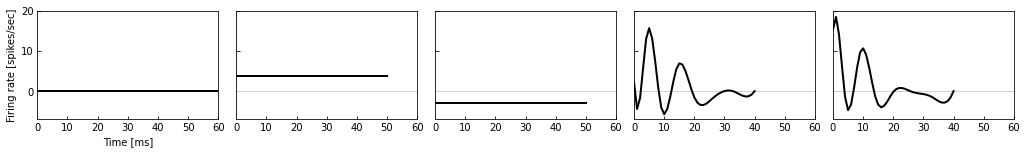

util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_kernel100ms_11252021_2242/group_model_pars_joint_itr4_20211126_055825.pkl


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   33.6s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  3.0min
[Parallel(n_jobs=12)]: Done 285 out of 285 | elapsed:  5.0min finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   36.5s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  3.3min
[Parallel(n_jobs=12)]: Done 285 out of 285 | elapsed:  5.4min finished


filter_membership.shape (672, 285)
membership cnt [(0.0, 44953), (3.0, 29290), (2.0, 50257), (1.0, 39424), (4.0, 27596)]
filter_membership.shape (648, 285)
membership cnt [(0.0, 34748), (3.0, 31435), (2.0, 51194), (1.0, 36691), (4.0, 30612)]
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_kernel100ms_11252021_2242/filter_membership_CD_itr5_20211126_060847.pkl
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_kernel100ms_11252021_2242/filter_membership_DE_itr5_20211126_060847.pkl
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_kernel100ms_11252021_2242/group_portion_itr5_20211126_060847.pkl
filter_membership.shape (1320, 285)
#all trials:76115	#batch trials:76115
X.shape (1359175, 3), basis_int

/home/yuchen/workspace/Brain_Network/Code/jitter.py:4090: UserWarning: Reach max itrs 60. Last err:2.550e-02
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


#all trials:58208	#batch trials:58208
X.shape (1353126, 11), basis_integral.shape (11, 1),beta.shape(11, 1)
100%|███████████████████████████████████████████████████████████████| 60/60 [00:11<00:00,  5.37it/s]
num itr 59 [[-2304531.66291127]] 0.026297172086413956
beta [ 1.39865737e+01  2.75684429e-02  1.51865737e+01  2.77549137e+01 -2.48696092e+01  2.45643902e+01
 -1.09729388e+01  3.13636111e+00 -9.52532899e-01 -2.53473347e-01 -4.87412201e+00]
gradient [-1.09113547 35.31927964 -2.4744482  -2.5570772  -0.65281329 -2.61147532 -0.17781167  0.72177277  0.46288951
  1.00905538  1.07533083]
Finish 4.


/home/yuchen/workspace/Brain_Network/Code/jitter.py:4090: UserWarning: Reach max itrs 60. Last err:2.630e-02
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


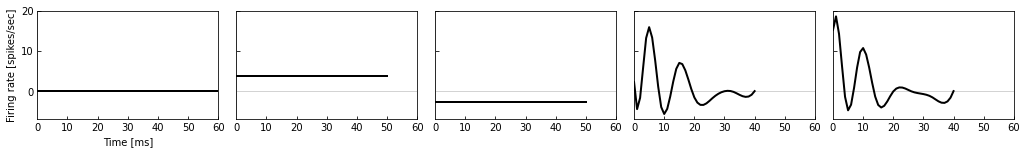

util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_kernel100ms_11252021_2242/group_model_pars_joint_itr5_20211126_062512.pkl


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   34.1s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  3.0min
[Parallel(n_jobs=12)]: Done 285 out of 285 | elapsed:  5.0min finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   35.7s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  3.4min
[Parallel(n_jobs=12)]: Done 285 out of 285 | elapsed:  5.4min finished


filter_membership.shape (672, 285)
membership cnt [(0.0, 44738), (3.0, 29353), (2.0, 50198), (1.0, 39336), (4.0, 27895)]
filter_membership.shape (648, 285)
membership cnt [(0.0, 34306), (3.0, 31615), (2.0, 51293), (1.0, 36667), (4.0, 30799)]
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_kernel100ms_11252021_2242/filter_membership_CD_itr6_20211126_063534.pkl
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_kernel100ms_11252021_2242/filter_membership_DE_itr6_20211126_063534.pkl
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_kernel100ms_11252021_2242/group_portion_itr6_20211126_063534.pkl
filter_membership.shape (1320, 285)
#all trials:76003	#batch trials:76003
X.shape (1356691, 3), basis_int

/home/yuchen/workspace/Brain_Network/Code/jitter.py:4090: UserWarning: Reach max itrs 60. Last err:2.604e-02
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


#all trials:58694	#batch trials:58694
X.shape (1360457, 11), basis_integral.shape (11, 1),beta.shape(11, 1)
100%|███████████████████████████████████████████████████████████████| 60/60 [00:11<00:00,  5.31it/s]
num itr 59 [[-2312871.92467968]] 0.026065405149566585
beta [ 1.39370650e+01  2.38592261e-02  1.49330361e+01  2.78089617e+01 -2.48189321e+01  2.44655067e+01
 -1.09953387e+01  3.28784930e+00 -9.07323274e-01 -2.65524218e-01 -4.83566493e+00]
gradient [-1.14796623 39.08912047 -2.476667   -2.57482186 -0.65134031 -2.6018131  -0.17351141  0.69011398  0.44554618
  1.02307213  1.09080794]
Finish 4.


/home/yuchen/workspace/Brain_Network/Code/jitter.py:4090: UserWarning: Reach max itrs 60. Last err:2.607e-02
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


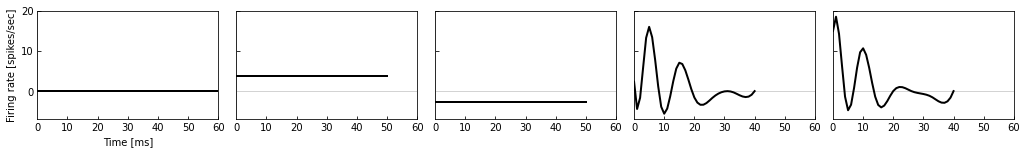

util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_kernel100ms_11252021_2242/group_model_pars_joint_itr6_20211126_065208.pkl


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   33.7s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  3.0min
[Parallel(n_jobs=12)]: Done 285 out of 285 | elapsed:  4.9min finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   35.9s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  3.3min
[Parallel(n_jobs=12)]: Done 285 out of 285 | elapsed:  5.4min finished


filter_membership.shape (672, 285)
membership cnt [(0.0, 44644), (3.0, 29345), (2.0, 50051), (1.0, 39641), (4.0, 27839)]
filter_membership.shape (648, 285)
membership cnt [(0.0, 34241), (3.0, 31458), (2.0, 51350), (1.0, 36781), (4.0, 30850)]
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_kernel100ms_11252021_2242/filter_membership_CD_itr7_20211126_070227.pkl
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_kernel100ms_11252021_2242/filter_membership_DE_itr7_20211126_070227.pkl
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_kernel100ms_11252021_2242/group_portion_itr7_20211126_070227.pkl
filter_membership.shape (1320, 285)
#all trials:76422	#batch trials:76422
X.shape (1359184, 3), basis_int

/home/yuchen/workspace/Brain_Network/Code/jitter.py:4090: UserWarning: Reach max itrs 60. Last err:2.789e-02
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


#all trials:58689	#batch trials:58689
X.shape (1359603, 11), basis_integral.shape (11, 1),beta.shape(11, 1)
100%|███████████████████████████████████████████████████████████████| 60/60 [00:11<00:00,  5.39it/s]
num itr 59 [[-2310862.67581699]] 0.02629458620773233
beta [ 1.39367824e+01  2.79073316e-02  1.48197008e+01  2.80393333e+01 -2.50752489e+01  2.45773891e+01
 -1.12246669e+01  3.46935151e+00 -9.65401659e-01 -2.25193936e-01 -4.91329272e+00]
gradient [-1.09192294 34.76935099 -2.47726904 -2.58571176 -0.64529444 -2.58864821 -0.15657193  0.65739461  0.41174136
  1.01199421  1.08800257]
Finish 4.


/home/yuchen/workspace/Brain_Network/Code/jitter.py:4090: UserWarning: Reach max itrs 60. Last err:2.629e-02
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


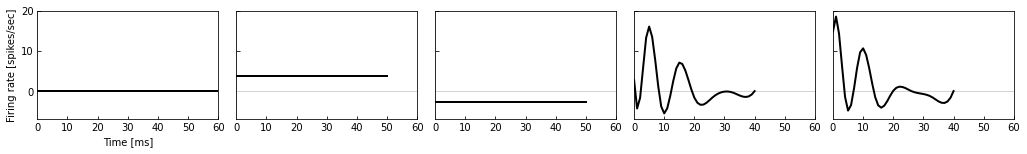

util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_kernel100ms_11252021_2242/group_model_pars_joint_itr7_20211126_071850.pkl


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   34.1s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  3.0min
[Parallel(n_jobs=12)]: Done 285 out of 285 | elapsed:  5.0min finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   36.3s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  3.3min
[Parallel(n_jobs=12)]: Done 285 out of 285 | elapsed:  5.4min finished


filter_membership.shape (672, 285)
membership cnt [(0.0, 44813), (3.0, 29121), (2.0, 50180), (1.0, 39422), (4.0, 27984)]
filter_membership.shape (648, 285)
membership cnt [(0.0, 34253), (3.0, 31372), (2.0, 51369), (1.0, 36737), (4.0, 30949)]
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_kernel100ms_11252021_2242/filter_membership_CD_itr8_20211126_072912.pkl
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_kernel100ms_11252021_2242/filter_membership_DE_itr8_20211126_072912.pkl
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_kernel100ms_11252021_2242/group_portion_itr8_20211126_072912.pkl
filter_membership.shape (1320, 285)
#all trials:76159	#batch trials:76159
X.shape (1357468, 3), basis_int

/home/yuchen/workspace/Brain_Network/Code/jitter.py:4090: UserWarning: Reach max itrs 60. Last err:2.808e-02
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


#all trials:58933	#batch trials:58933
X.shape (1360206, 11), basis_integral.shape (11, 1),beta.shape(11, 1)
100%|███████████████████████████████████████████████████████████████| 60/60 [00:11<00:00,  5.41it/s]
num itr 59 [[-2306719.43651597]] 0.025968715762044084
beta [ 1.38776865e+01  2.42352974e-02  1.45146517e+01  2.80531538e+01 -2.49978644e+01  2.44322203e+01
 -1.12111878e+01  3.61222317e+00 -9.61723858e-01 -1.93618350e-01 -4.90116432e+00]
gradient [-1.1746616  38.27664843 -2.47017098 -2.59814175 -0.64613347 -2.57230256 -0.17573954  0.6064728   0.39079318
  1.01409137  1.09234168]
Finish 4.


/home/yuchen/workspace/Brain_Network/Code/jitter.py:4090: UserWarning: Reach max itrs 60. Last err:2.597e-02
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


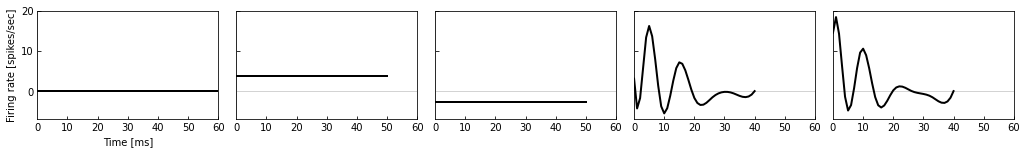

util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_kernel100ms_11252021_2242/group_model_pars_joint_itr8_20211126_074549.pkl


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   33.9s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  3.0min
[Parallel(n_jobs=12)]: Done 285 out of 285 | elapsed:  4.9min finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   35.7s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  3.3min
[Parallel(n_jobs=12)]: Done 285 out of 285 | elapsed:  5.3min finished


filter_membership.shape (672, 285)
membership cnt [(0.0, 44732), (3.0, 29086), (2.0, 50323), (1.0, 39354), (4.0, 28025)]
filter_membership.shape (648, 285)
membership cnt [(0.0, 34406), (3.0, 31259), (2.0, 51319), (1.0, 36809), (4.0, 30887)]
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_kernel100ms_11252021_2242/filter_membership_CD_itr9_20211126_075605.pkl
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_kernel100ms_11252021_2242/filter_membership_DE_itr9_20211126_075605.pkl
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_kernel100ms_11252021_2242/group_portion_itr9_20211126_075606.pkl
filter_membership.shape (1320, 285)
#all trials:76163	#batch trials:76163
X.shape (1357763, 3), basis_int

/home/yuchen/workspace/Brain_Network/Code/jitter.py:4090: UserWarning: Reach max itrs 60. Last err:2.732e-02
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


#all trials:58912	#batch trials:58912
X.shape (1360004, 11), basis_integral.shape (11, 1),beta.shape(11, 1)
100%|███████████████████████████████████████████████████████████████| 60/60 [00:11<00:00,  5.44it/s]
num itr 59 [[-2306671.78936183]] 0.026047568424543165
beta [ 1.38787781e+01  2.44191861e-02  1.43089864e+01  2.82701968e+01 -2.51494213e+01  2.44818371e+01
 -1.13696201e+01  3.80482252e+00 -9.97619679e-01 -1.57855445e-01 -4.92452965e+00]
gradient [-1.15847947 38.55009301 -2.46203166 -2.60374724 -0.63354829 -2.54611816 -0.14826671  0.58139053  0.37153538
  1.01610862  1.09811098]
Finish 4.


/home/yuchen/workspace/Brain_Network/Code/jitter.py:4090: UserWarning: Reach max itrs 60. Last err:2.605e-02
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


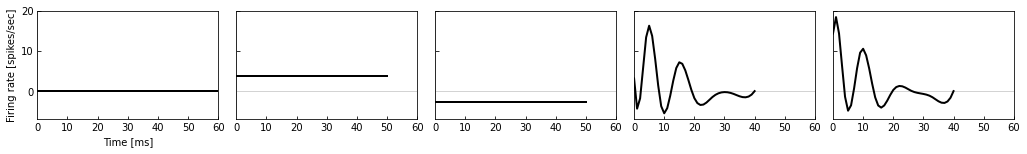

util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_kernel100ms_11252021_2242/group_model_pars_joint_itr9_20211126_081230.pkl


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   33.8s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  3.0min
[Parallel(n_jobs=12)]: Done 285 out of 285 | elapsed:  4.9min finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   35.9s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  3.3min
[Parallel(n_jobs=12)]: Done 285 out of 285 | elapsed:  5.3min finished


filter_membership.shape (672, 285)
membership cnt [(0.0, 44763), (3.0, 29127), (2.0, 50212), (1.0, 39393), (4.0, 28025)]
filter_membership.shape (648, 285)
membership cnt [(0.0, 34351), (3.0, 31245), (2.0, 51414), (1.0, 36733), (4.0, 30937)]
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_kernel100ms_11252021_2242/filter_membership_CD_itr10_20211126_082247.pkl
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_kernel100ms_11252021_2242/filter_membership_DE_itr10_20211126_082247.pkl
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_kernel100ms_11252021_2242/group_portion_itr10_20211126_082247.pkl
filter_membership.shape (1320, 285)
#all trials:76126	#batch trials:76126
X.shape (1357908, 3), basis_

/home/yuchen/workspace/Brain_Network/Code/jitter.py:4090: UserWarning: Reach max itrs 60. Last err:2.740e-02
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


#all trials:58962	#batch trials:58962
X.shape (1360973, 11), basis_integral.shape (11, 1),beta.shape(11, 1)
100%|███████████████████████████████████████████████████████████████| 60/60 [00:11<00:00,  5.38it/s]
num itr 59 [[-2308150.49553496]] 0.026123011125812133
beta [ 1.38759930e+01  2.46477862e-02  1.41045334e+01  2.84762674e+01 -2.52972872e+01  2.45367549e+01
 -1.15189614e+01  3.99167268e+00 -1.04005893e+00 -1.12507384e-01 -4.96261047e+00]
gradient [-1.15891047 37.88712048 -2.45460348 -2.61198192 -0.63039146 -2.52985837 -0.14354165  0.54205229  0.34671949
  1.01221433  1.09949919]
Finish 4.


/home/yuchen/workspace/Brain_Network/Code/jitter.py:4090: UserWarning: Reach max itrs 60. Last err:2.612e-02
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


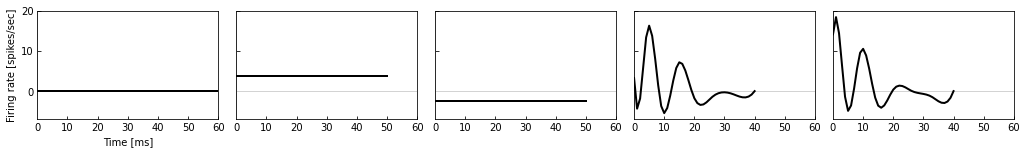

util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_kernel100ms_11252021_2242/group_model_pars_joint_itr10_20211126_083917.pkl


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   33.6s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  3.0min
[Parallel(n_jobs=12)]: Done 285 out of 285 | elapsed:  4.9min finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   36.2s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  3.3min
[Parallel(n_jobs=12)]: Done 285 out of 285 | elapsed:  5.3min finished


filter_membership.shape (672, 285)
membership cnt [(0.0, 44083), (3.0, 29389), (2.0, 49894), (1.0, 39561), (4.0, 28593)]
filter_membership.shape (648, 285)
membership cnt [(0.0, 33563), (3.0, 31587), (2.0, 51293), (1.0, 36869), (4.0, 31368)]
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_kernel100ms_11252021_2242/filter_membership_CD_itr11_20211126_084933.pkl
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_kernel100ms_11252021_2242/filter_membership_DE_itr11_20211126_084933.pkl
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_kernel100ms_11252021_2242/group_portion_itr11_20211126_084933.pkl
filter_membership.shape (1320, 285)
#all trials:76430	#batch trials:76430
X.shape (1358356, 3), basis_

/home/yuchen/workspace/Brain_Network/Code/jitter.py:4090: UserWarning: Reach max itrs 60. Last err:2.091e-02
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


#all trials:59961	#batch trials:59961
X.shape (1379070, 11), basis_integral.shape (11, 1),beta.shape(11, 1)
100%|███████████████████████████████████████████████████████████████| 60/60 [00:11<00:00,  5.22it/s]
num itr 59 [[-2333647.35696369]] 0.025826430896899354
beta [ 1.38312657e+01  2.42083764e-02  1.37577748e+01  2.84674773e+01 -2.52450107e+01  2.43840942e+01
 -1.15568533e+01  4.11869481e+00 -1.06482110e+00 -1.09898530e-01 -4.97146193e+00]
gradient [-1.20622371 39.35830501 -2.46880023 -2.64635275 -0.63394417 -2.5367776  -0.14447119  0.50908106  0.33728726
  1.03103193  1.11909019]
Finish 4.


/home/yuchen/workspace/Brain_Network/Code/jitter.py:4090: UserWarning: Reach max itrs 60. Last err:2.583e-02
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


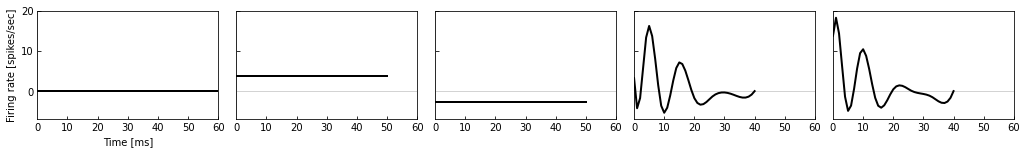

util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_kernel100ms_11252021_2242/group_model_pars_joint_itr11_20211126_090619.pkl


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   33.9s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  3.0min
[Parallel(n_jobs=12)]: Done 285 out of 285 | elapsed:  5.0min finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   36.7s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  3.3min
[Parallel(n_jobs=12)]: Done 285 out of 285 | elapsed:  5.5min finished


filter_membership.shape (672, 285)
membership cnt [(0.0, 44759), (3.0, 28895), (2.0, 50248), (1.0, 39371), (4.0, 28247)]
filter_membership.shape (648, 285)
membership cnt [(0.0, 34378), (3.0, 31204), (2.0, 51302), (1.0, 36741), (4.0, 31055)]
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_kernel100ms_11252021_2242/filter_membership_CD_itr12_20211126_091651.pkl
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_kernel100ms_11252021_2242/filter_membership_DE_itr12_20211126_091651.pkl
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_kernel100ms_11252021_2242/group_portion_itr12_20211126_091651.pkl
filter_membership.shape (1320, 285)
#all trials:76112	#batch trials:76112
X.shape (1357120, 3), basis_

/home/yuchen/workspace/Brain_Network/Code/jitter.py:4090: UserWarning: Reach max itrs 60. Last err:2.328e-02
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


#all trials:59302	#batch trials:59302
X.shape (1365893, 11), basis_integral.shape (11, 1),beta.shape(11, 1)
100%|███████████████████████████████████████████████████████████████| 60/60 [00:11<00:00,  5.34it/s]
num itr 59 [[-2313625.7339276]] 0.026315297976916348
beta [ 1.38542599e+01  2.80527632e-02  1.37095258e+01  2.87853441e+01 -2.55521426e+01  2.45907699e+01
 -1.18176316e+01  4.32686137e+00 -1.12567986e+00 -9.40157868e-02 -5.04341332e+00]
gradient [-1.09777612 35.95868607 -2.45124445 -2.63094031 -0.61098324 -2.50094475 -0.09152878  0.49848596  0.32458631
  1.03340048  1.12319688]
Finish 4.


/home/yuchen/workspace/Brain_Network/Code/jitter.py:4090: UserWarning: Reach max itrs 60. Last err:2.632e-02
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


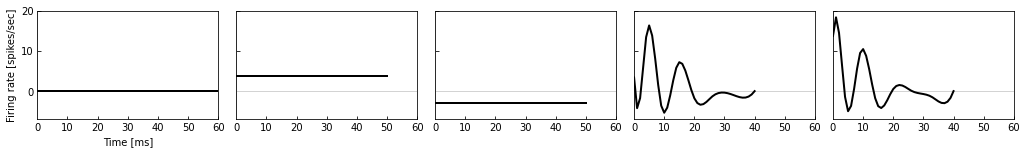

util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_kernel100ms_11252021_2242/group_model_pars_joint_itr12_20211126_093328.pkl


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   34.2s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  3.0min
[Parallel(n_jobs=12)]: Done 285 out of 285 | elapsed:  5.0min finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   35.9s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  3.3min
[Parallel(n_jobs=12)]: Done 285 out of 285 | elapsed:  5.3min finished


filter_membership.shape (672, 285)
membership cnt [(0.0, 44912), (3.0, 28781), (2.0, 50350), (1.0, 39283), (4.0, 28194)]
filter_membership.shape (648, 285)
membership cnt [(0.0, 34606), (3.0, 31052), (2.0, 51312), (1.0, 36696), (4.0, 31014)]
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_kernel100ms_11252021_2242/filter_membership_CD_itr13_20211126_094346.pkl
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_kernel100ms_11252021_2242/filter_membership_DE_itr13_20211126_094346.pkl
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_kernel100ms_11252021_2242/group_portion_itr13_20211126_094346.pkl
filter_membership.shape (1320, 285)
#all trials:75979	#batch trials:75979
X.shape (1355874, 3), basis_

/home/yuchen/workspace/Brain_Network/Code/jitter.py:4090: UserWarning: Reach max itrs 60. Last err:2.227e-02
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


#all trials:59208	#batch trials:59208
X.shape (1363103, 11), basis_integral.shape (11, 1),beta.shape(11, 1)
100%|███████████████████████████████████████████████████████████████| 60/60 [00:11<00:00,  5.35it/s]
num itr 59 [[-2308182.85508317]] 0.02627801206353616
beta [ 1.38448387e+01  2.71920769e-02  1.34869250e+01  2.88798219e+01 -2.56088413e+01  2.46160474e+01
 -1.19558622e+01  4.50927697e+00 -1.11462204e+00 -1.15569405e-01 -5.02289381e+00]
gradient [-1.09978721 36.86096204 -2.43059286 -2.62125322 -0.60225452 -2.4745018  -0.07129553  0.46365967  0.30269747
  1.03893253  1.12515302]
Finish 4.


/home/yuchen/workspace/Brain_Network/Code/jitter.py:4090: UserWarning: Reach max itrs 60. Last err:2.628e-02
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


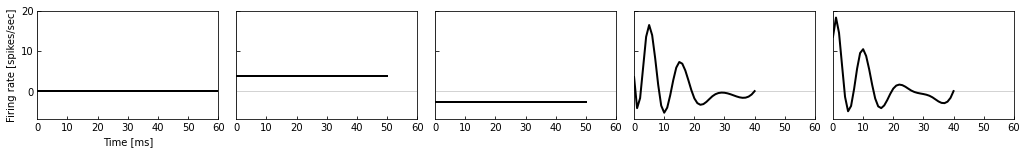

util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_kernel100ms_11252021_2242/group_model_pars_joint_itr13_20211126_100012.pkl


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   33.4s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  3.0min
[Parallel(n_jobs=12)]: Done 285 out of 285 | elapsed:  4.9min finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   35.4s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  3.3min
[Parallel(n_jobs=12)]: Done 285 out of 285 | elapsed:  5.3min finished


filter_membership.shape (672, 285)
membership cnt [(0.0, 44477), (3.0, 29071), (2.0, 49956), (1.0, 39500), (4.0, 28516)]
filter_membership.shape (648, 285)
membership cnt [(0.0, 34159), (3.0, 31210), (2.0, 51325), (1.0, 36654), (4.0, 31332)]
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_kernel100ms_11252021_2242/filter_membership_CD_itr14_20211126_101027.pkl
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_kernel100ms_11252021_2242/filter_membership_DE_itr14_20211126_101027.pkl
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_kernel100ms_11252021_2242/group_portion_itr14_20211126_101027.pkl
filter_membership.shape (1320, 285)
#all trials:76154	#batch trials:76154
X.shape (1355846, 3), basis_

/home/yuchen/workspace/Brain_Network/Code/jitter.py:4090: UserWarning: Reach max itrs 60. Last err:2.913e-02
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


#all trials:59848	#batch trials:59848
X.shape (1374023, 11), basis_integral.shape (11, 1),beta.shape(11, 1)
100%|███████████████████████████████████████████████████████████████| 60/60 [00:11<00:00,  5.32it/s]
num itr 59 [[-2322837.03267986]] 0.02617717915130005
beta [ 13.81306034   0.0288896   13.26263286  28.87535483 -25.63159244  24.58519279 -12.09705067   4.68702646
  -1.16741283  -0.13800359  -5.02918789]
gradient [-1.10569397 35.77591705 -2.44121141 -2.64413459 -0.60521881 -2.48361582 -0.06627074  0.42291074  0.28498605
  1.05311052  1.13614621]
Finish 4.


/home/yuchen/workspace/Brain_Network/Code/jitter.py:4090: UserWarning: Reach max itrs 60. Last err:2.618e-02
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


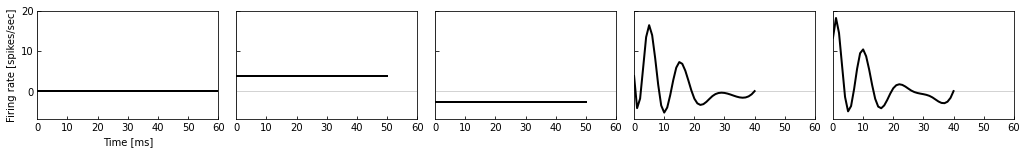

util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_kernel100ms_11252021_2242/group_model_pars_joint_itr14_20211126_102701.pkl


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   33.8s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  3.0min
[Parallel(n_jobs=12)]: Done 285 out of 285 | elapsed:  4.9min finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   35.8s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  3.3min
[Parallel(n_jobs=12)]: Done 285 out of 285 | elapsed:  5.3min finished


filter_membership.shape (672, 285)
membership cnt [(0.0, 44698), (3.0, 28821), (2.0, 50142), (1.0, 39389), (4.0, 28470)]
filter_membership.shape (648, 285)
membership cnt [(0.0, 34340), (3.0, 31063), (2.0, 51222), (1.0, 36734), (4.0, 31321)]
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_kernel100ms_11252021_2242/filter_membership_CD_itr15_20211126_103718.pkl
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_kernel100ms_11252021_2242/filter_membership_DE_itr15_20211126_103718.pkl
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_kernel100ms_11252021_2242/group_portion_itr15_20211126_103718.pkl
filter_membership.shape (1320, 285)
#all trials:76123	#batch trials:76123
X.shape (1355041, 3), basis_

/home/yuchen/workspace/Brain_Network/Code/jitter.py:4090: UserWarning: Reach max itrs 60. Last err:2.501e-02
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


#all trials:59791	#batch trials:59791
X.shape (1373394, 11), basis_integral.shape (11, 1),beta.shape(11, 1)
100%|███████████████████████████████████████████████████████████████| 60/60 [00:11<00:00,  5.25it/s]
num itr 59 [[-2322227.8609755]] 0.0259948149159396
beta [ 1.38188416e+01  2.71826584e-02  1.30583316e+01  2.88582123e+01 -2.56024391e+01  2.45588478e+01
 -1.21829274e+01  4.86725533e+00 -1.20505248e+00 -1.43939877e-01 -5.02978241e+00]
gradient [-1.13242459 37.88688736 -2.41886875 -2.62975484 -0.59930877 -2.45964867 -0.05851093  0.38639055  0.27740759
  1.06381984  1.14094457]
Finish 4.


/home/yuchen/workspace/Brain_Network/Code/jitter.py:4090: UserWarning: Reach max itrs 60. Last err:2.599e-02
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


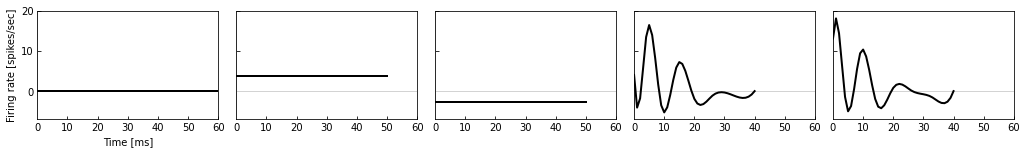

util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_kernel100ms_11252021_2242/group_model_pars_joint_itr15_20211126_105348.pkl


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   33.8s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  3.0min
[Parallel(n_jobs=12)]: Done 285 out of 285 | elapsed:  4.9min finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   35.4s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  3.3min
[Parallel(n_jobs=12)]: Done 285 out of 285 | elapsed:  5.3min finished


filter_membership.shape (672, 285)
membership cnt [(0.0, 44448), (3.0, 28915), (2.0, 50055), (1.0, 39431), (4.0, 28671)]
filter_membership.shape (648, 285)
membership cnt [(0.0, 34062), (3.0, 31223), (2.0, 51319), (1.0, 36646), (4.0, 31430)]
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_kernel100ms_11252021_2242/filter_membership_CD_itr16_20211126_110401.pkl
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_kernel100ms_11252021_2242/filter_membership_DE_itr16_20211126_110401.pkl
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_kernel100ms_11252021_2242/group_portion_itr16_20211126_110401.pkl
filter_membership.shape (1320, 285)
#all trials:76077	#batch trials:76077
X.shape (1353145, 3), basis_

/home/yuchen/workspace/Brain_Network/Code/jitter.py:4090: UserWarning: Reach max itrs 60. Last err:2.179e-02
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


#all trials:60101	#batch trials:60101
X.shape (1379001, 11), basis_integral.shape (11, 1),beta.shape(11, 1)
100%|███████████████████████████████████████████████████████████████| 60/60 [00:11<00:00,  5.24it/s]
num itr 59 [[-2330295.6081573]] 0.026061989304844546
beta [ 13.80956928   0.02967596  12.89516122  28.94090818 -25.73883341  24.65300605 -12.34217649   5.04297876
  -1.27559683  -0.15645321  -5.07175101]
gradient [-1.11783712 34.8918564  -2.4211398  -2.64179858 -0.60585406 -2.47716784 -0.07238053  0.33579758  0.25426779
  1.06844046  1.14393772]
Finish 4.


/home/yuchen/workspace/Brain_Network/Code/jitter.py:4090: UserWarning: Reach max itrs 60. Last err:2.606e-02
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


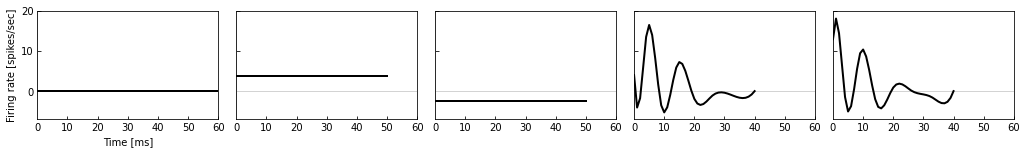

util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_kernel100ms_11252021_2242/group_model_pars_joint_itr16_20211126_112029.pkl


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   33.8s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  3.0min
[Parallel(n_jobs=12)]: Done 285 out of 285 | elapsed:  4.9min finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   35.4s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  3.3min
[Parallel(n_jobs=12)]: Done 285 out of 285 | elapsed:  5.3min finished


filter_membership.shape (672, 285)
membership cnt [(0.0, 44262), (3.0, 29157), (2.0, 49869), (1.0, 39360), (4.0, 28872)]
filter_membership.shape (648, 285)
membership cnt [(0.0, 33772), (3.0, 31231), (2.0, 51254), (1.0, 36764), (4.0, 31659)]
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_kernel100ms_11252021_2242/filter_membership_CD_itr17_20211126_113045.pkl
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_kernel100ms_11252021_2242/filter_membership_DE_itr17_20211126_113045.pkl
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_kernel100ms_11252021_2242/group_portion_itr17_20211126_113045.pkl
filter_membership.shape (1320, 285)
#all trials:76124	#batch trials:76124
X.shape (1354112, 3), basis_

/home/yuchen/workspace/Brain_Network/Code/jitter.py:4090: UserWarning: Reach max itrs 60. Last err:2.201e-02
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


#all trials:60531	#batch trials:60531
X.shape (1385411, 11), basis_integral.shape (11, 1),beta.shape(11, 1)
100%|███████████████████████████████████████████████████████████████| 60/60 [00:11<00:00,  5.19it/s]
num itr 59 [[-2337587.56136048]] 0.025883502634709267
beta [ 13.78022947   0.0302135   12.70643906  28.84446244 -25.69279318  24.60571584 -12.4263265    5.1846073
  -1.31014819  -0.19853624  -5.06423134]
gradient [-1.1428323  34.36089486 -2.41886335 -2.64643282 -0.61035459 -2.48576591 -0.08118673  0.29010757  0.23641571
  1.0785943   1.14890973]
Finish 4.


/home/yuchen/workspace/Brain_Network/Code/jitter.py:4090: UserWarning: Reach max itrs 60. Last err:2.588e-02
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


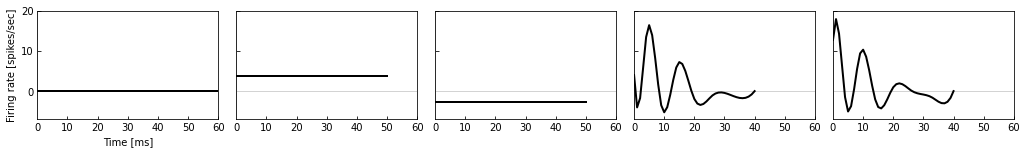

util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_kernel100ms_11252021_2242/group_model_pars_joint_itr17_20211126_114717.pkl


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   33.7s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  3.0min
[Parallel(n_jobs=12)]: Done 285 out of 285 | elapsed:  4.9min finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   36.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  3.3min
[Parallel(n_jobs=12)]: Done 285 out of 285 | elapsed:  5.3min finished


filter_membership.shape (672, 285)
membership cnt [(0.0, 44598), (3.0, 28859), (2.0, 50206), (1.0, 39162), (4.0, 28695)]
filter_membership.shape (648, 285)
membership cnt [(0.0, 34174), (3.0, 31113), (2.0, 51379), (1.0, 36473), (4.0, 31541)]
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_kernel100ms_11252021_2242/filter_membership_CD_itr18_20211126_115730.pkl
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_kernel100ms_11252021_2242/filter_membership_DE_itr18_20211126_115730.pkl
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_kernel100ms_11252021_2242/group_portion_itr18_20211126_115730.pkl
filter_membership.shape (1320, 285)
#all trials:75635	#batch trials:75635
X.shape (1352387, 3), basis_

/home/yuchen/workspace/Brain_Network/Code/jitter.py:4090: UserWarning: Reach max itrs 60. Last err:2.225e-02
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


#all trials:60236	#batch trials:60236
X.shape (1380696, 11), basis_integral.shape (11, 1),beta.shape(11, 1)
100%|███████████████████████████████████████████████████████████████| 60/60 [00:11<00:00,  5.17it/s]
num itr 59 [[-2331646.97011831]] 0.025998711000353752
beta [ 13.80157247   0.03107978  12.6188976   28.91353314 -25.79243647  24.72166902 -12.59383451   5.3750667
  -1.36453569  -0.22282696  -5.07583804]
gradient [-1.10232062 34.05021929 -2.39827708 -2.62543959 -0.59959275 -2.46822003 -0.05597836  0.27048658  0.2381029
  1.09452704  1.15432498]
Finish 4.


/home/yuchen/workspace/Brain_Network/Code/jitter.py:4090: UserWarning: Reach max itrs 60. Last err:2.600e-02
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


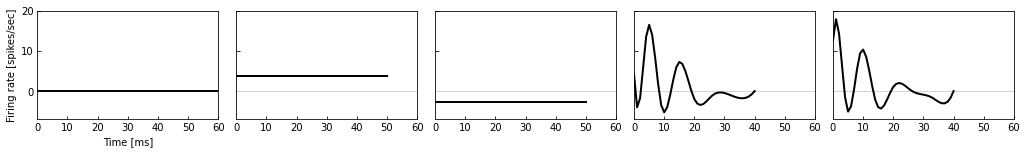

util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_kernel100ms_11252021_2242/group_model_pars_joint_itr18_20211126_121358.pkl


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   34.8s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  3.1min
[Parallel(n_jobs=12)]: Done 285 out of 285 | elapsed:  5.0min finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   36.4s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  3.4min
[Parallel(n_jobs=12)]: Done 285 out of 285 | elapsed:  5.5min finished


filter_membership.shape (672, 285)
membership cnt [(0.0, 44739), (3.0, 28787), (2.0, 50101), (1.0, 39146), (4.0, 28747)]
filter_membership.shape (648, 285)
membership cnt [(0.0, 34342), (3.0, 30930), (2.0, 51160), (1.0, 36734), (4.0, 31514)]
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_kernel100ms_11252021_2242/filter_membership_CD_itr19_20211126_122427.pkl
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_kernel100ms_11252021_2242/filter_membership_DE_itr19_20211126_122427.pkl
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_kernel100ms_11252021_2242/group_portion_itr19_20211126_122427.pkl
filter_membership.shape (1320, 285)
#all trials:75880	#batch trials:75880
X.shape (1352319, 3), basis_

/home/yuchen/workspace/Brain_Network/Code/jitter.py:4090: UserWarning: Reach max itrs 60. Last err:2.538e-02
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


#all trials:60261	#batch trials:60261
X.shape (1377748, 11), basis_integral.shape (11, 1),beta.shape(11, 1)
100%|███████████████████████████████████████████████████████████████| 60/60 [00:11<00:00,  5.34it/s]
num itr 59 [[-2323105.01820037]] 0.02578886664342212
beta [ 13.76139757   0.02899495  12.53353806  28.7613921  -25.68234973  24.66763449 -12.66204494   5.55289368
  -1.38954383  -0.23327779  -5.03789735]
gradient [-1.15355665 35.80079944 -2.38918086 -2.61682443 -0.60146978 -2.4586076  -0.06526052  0.21638644  0.21974002
  1.09905622  1.15327705]
Finish 4.


/home/yuchen/workspace/Brain_Network/Code/jitter.py:4090: UserWarning: Reach max itrs 60. Last err:2.579e-02
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


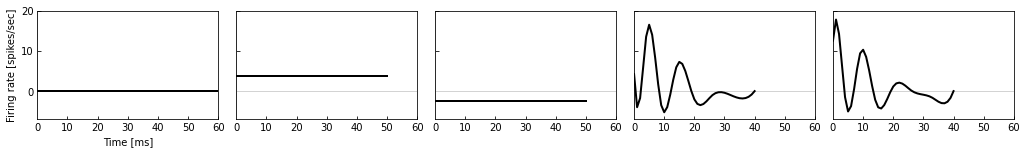

util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_kernel100ms_11252021_2242/group_model_pars_joint_itr19_20211126_124117.pkl


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   34.1s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  3.0min
[Parallel(n_jobs=12)]: Done 285 out of 285 | elapsed:  5.0min finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   36.1s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  3.4min
[Parallel(n_jobs=12)]: Done 285 out of 285 | elapsed:  5.4min finished


filter_membership.shape (672, 285)
membership cnt [(0.0, 44211), (3.0, 29102), (2.0, 49731), (1.0, 39498), (4.0, 28978)]
filter_membership.shape (648, 285)
membership cnt [(0.0, 33766), (3.0, 31172), (2.0, 51241), (1.0, 36697), (4.0, 31804)]
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_kernel100ms_11252021_2242/filter_membership_CD_itr20_20211126_125141.pkl
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_kernel100ms_11252021_2242/filter_membership_DE_itr20_20211126_125141.pkl
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_kernel100ms_11252021_2242/group_portion_itr20_20211126_125141.pkl
filter_membership.shape (1320, 285)
#all trials:76195	#batch trials:76195
X.shape (1353355, 3), basis_

/home/yuchen/workspace/Brain_Network/Code/jitter.py:4090: UserWarning: Reach max itrs 60. Last err:2.196e-02
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


#all trials:60782	#batch trials:60782
X.shape (1389233, 11), basis_integral.shape (11, 1),beta.shape(11, 1)
100%|███████████████████████████████████████████████████████████████| 60/60 [00:11<00:00,  5.30it/s]
num itr 59 [[-2341997.74898482]] 0.02586077874410813
beta [ 13.766206     0.03151035  12.48032506  28.76205388 -25.73734179  24.69812735 -12.80146484   5.69776564
  -1.46296664  -0.27386542  -5.04612919]
gradient [-1.11334565 34.25275842 -2.40195555 -2.62877544 -0.59641687 -2.46493639 -0.03854189  0.20782871  0.22986204
  1.12730677  1.17011253]
Finish 4.


/home/yuchen/workspace/Brain_Network/Code/jitter.py:4090: UserWarning: Reach max itrs 60. Last err:2.586e-02
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


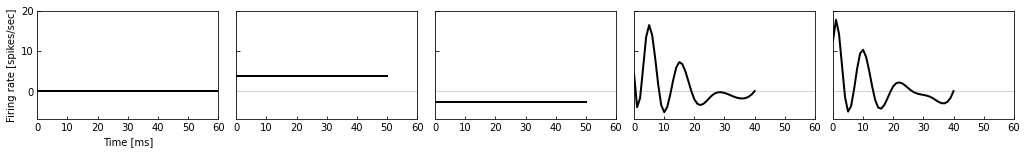

util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_kernel100ms_11252021_2242/group_model_pars_joint_itr20_20211126_130827.pkl


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   34.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  3.0min
[Parallel(n_jobs=12)]: Done 285 out of 285 | elapsed:  5.0min finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   35.9s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  3.4min
[Parallel(n_jobs=12)]: Done 285 out of 285 | elapsed:  5.4min finished


filter_membership.shape (672, 285)
membership cnt [(0.0, 44490), (3.0, 28957), (2.0, 50089), (1.0, 39127), (4.0, 28857)]
filter_membership.shape (648, 285)
membership cnt [(0.0, 34123), (3.0, 31038), (2.0, 51251), (1.0, 36627), (4.0, 31641)]
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_kernel100ms_11252021_2242/filter_membership_CD_itr21_20211126_131848.pkl
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_kernel100ms_11252021_2242/filter_membership_DE_itr21_20211126_131848.pkl
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_kernel100ms_11252021_2242/group_portion_itr21_20211126_131848.pkl
filter_membership.shape (1320, 285)
#all trials:75754	#batch trials:75754
X.shape (1352288, 3), basis_

/home/yuchen/workspace/Brain_Network/Code/jitter.py:4090: UserWarning: Reach max itrs 60. Last err:2.644e-02
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


#all trials:60498	#batch trials:60498
X.shape (1384203, 11), basis_integral.shape (11, 1),beta.shape(11, 1)
100%|███████████████████████████████████████████████████████████████| 60/60 [00:11<00:00,  5.31it/s]
num itr 59 [[-2335043.12880133]] 0.02597492486784092
beta [ 13.77541501   0.03095704  12.47879604  28.79994248 -25.8128082   24.82736098 -12.95033827   5.8961411
  -1.52630807  -0.26097082  -5.03298328]
gradient [-1.09953373e+00  3.45777660e+01 -2.38891331e+00 -2.61097931e+00 -5.90902579e-01 -2.45425772e+00
 -2.45363832e-02  1.81155321e-01  2.26746453e-01  1.13399350e+00  1.16797211e+00]
Finish 4.


/home/yuchen/workspace/Brain_Network/Code/jitter.py:4090: UserWarning: Reach max itrs 60. Last err:2.597e-02
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


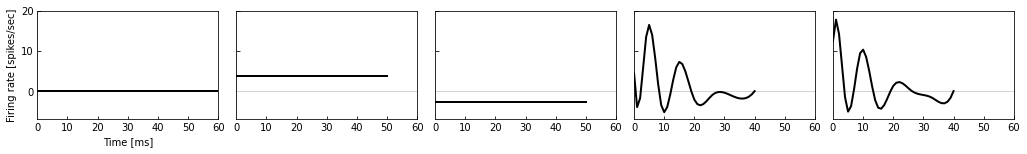

util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_kernel100ms_11252021_2242/group_model_pars_joint_itr21_20211126_133533.pkl


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   33.7s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  3.0min
[Parallel(n_jobs=12)]: Done 285 out of 285 | elapsed:  5.0min finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   37.5s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  3.4min
[Parallel(n_jobs=12)]: Done 285 out of 285 | elapsed:  5.4min finished


filter_membership.shape (672, 285)
membership cnt [(0.0, 44645), (3.0, 28860), (2.0, 50017), (1.0, 39095), (4.0, 28903)]
filter_membership.shape (648, 285)
membership cnt [(0.0, 34241), (3.0, 31018), (2.0, 51122), (1.0, 36597), (4.0, 31702)]
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_kernel100ms_11252021_2242/filter_membership_CD_itr22_20211126_134559.pkl
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_kernel100ms_11252021_2242/filter_membership_DE_itr22_20211126_134559.pkl
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_kernel100ms_11252021_2242/group_portion_itr22_20211126_134559.pkl
filter_membership.shape (1320, 285)
#all trials:75692	#batch trials:75692
X.shape (1350114, 3), basis_

/home/yuchen/workspace/Brain_Network/Code/jitter.py:4090: UserWarning: Reach max itrs 60. Last err:2.265e-02
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


#all trials:60605	#batch trials:60605
X.shape (1383976, 11), basis_integral.shape (11, 1),beta.shape(11, 1)
100%|███████████████████████████████████████████████████████████████| 60/60 [00:11<00:00,  5.29it/s]
num itr 59 [[-2332045.29318741]] 0.02606305095289703
beta [ 13.75282607   0.03275742  12.41602948  28.78806933 -25.87267126  24.86407943 -13.09916585   6.086898
  -1.6214678   -0.25627108  -5.03110967]
gradient [-1.06277546e+00  3.37173311e+01 -2.38969902e+00 -2.60818338e+00 -5.79082667e-01 -2.44564713e+00
  9.79747487e-04  1.64312341e-01  2.34263213e-01  1.15163716e+00  1.17446288e+00]
Finish 4.


/home/yuchen/workspace/Brain_Network/Code/jitter.py:4090: UserWarning: Reach max itrs 60. Last err:2.606e-02
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


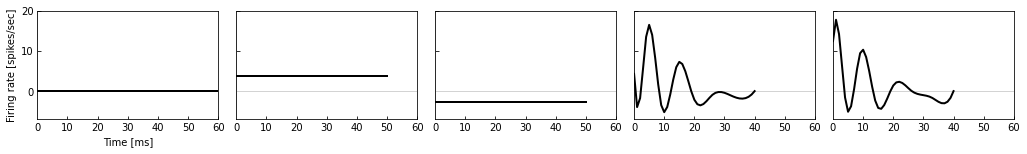

util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_kernel100ms_11252021_2242/group_model_pars_joint_itr22_20211126_140223.pkl


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   33.9s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  3.0min
[Parallel(n_jobs=12)]: Done 285 out of 285 | elapsed:  4.9min finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   36.3s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  3.4min
[Parallel(n_jobs=12)]: Done 285 out of 285 | elapsed:  5.4min finished


filter_membership.shape (672, 285)
membership cnt [(0.0, 44514), (3.0, 28888), (2.0, 50040), (1.0, 39086), (4.0, 28992)]
filter_membership.shape (648, 285)
membership cnt [(0.0, 34170), (3.0, 31089), (2.0, 51147), (1.0, 36491), (4.0, 31783)]
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_kernel100ms_11252021_2242/filter_membership_CD_itr23_20211126_141242.pkl
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_kernel100ms_11252021_2242/filter_membership_DE_itr23_20211126_141242.pkl
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_kernel100ms_11252021_2242/group_portion_itr23_20211126_141242.pkl
filter_membership.shape (1320, 285)
#all trials:75577	#batch trials:75577
X.shape (1350051, 3), basis_

/home/yuchen/workspace/Brain_Network/Code/jitter.py:4090: UserWarning: Reach max itrs 60. Last err:2.873e-02
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


#all trials:60775	#batch trials:60775
X.shape (1386534, 11), basis_integral.shape (11, 1),beta.shape(11, 1)
100%|███████████████████████████████████████████████████████████████| 60/60 [00:11<00:00,  5.30it/s]
num itr 59 [[-2334781.71111239]] 0.025752056024842703
beta [ 13.73329682   0.02912401  12.31823689  28.63124021 -25.72509478  24.78570901 -13.12648472   6.25880258
  -1.68284185  -0.21872064  -4.99714344]
gradient [-1.12843049e+00  3.75848029e+01 -2.37992747e+00 -2.59715825e+00 -5.77062864e-01 -2.43303371e+00
 -5.31169353e-03  1.25182579e-01  2.35056036e-01  1.16374974e+00  1.17802779e+00]
Finish 4.


/home/yuchen/workspace/Brain_Network/Code/jitter.py:4090: UserWarning: Reach max itrs 60. Last err:2.575e-02
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


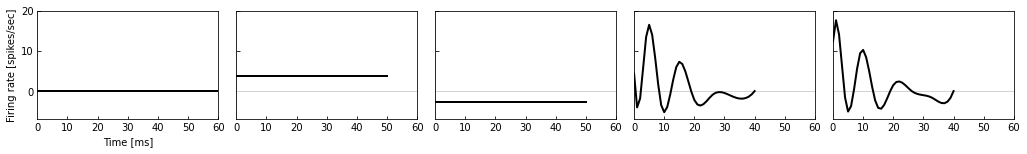

util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_kernel100ms_11252021_2242/group_model_pars_joint_itr23_20211126_142909.pkl


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   33.8s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  3.0min
[Parallel(n_jobs=12)]: Done 285 out of 285 | elapsed:  5.0min finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   35.9s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  3.3min
[Parallel(n_jobs=12)]: Done 285 out of 285 | elapsed:  5.4min finished


filter_membership.shape (672, 285)
membership cnt [(0.0, 44499), (3.0, 28941), (2.0, 49778), (1.0, 39317), (4.0, 28985)]
filter_membership.shape (648, 285)
membership cnt [(0.0, 34090), (3.0, 31128), (2.0, 51105), (1.0, 36575), (4.0, 31782)]
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_kernel100ms_11252021_2242/filter_membership_CD_itr24_20211126_143931.pkl
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_kernel100ms_11252021_2242/filter_membership_DE_itr24_20211126_143931.pkl
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_kernel100ms_11252021_2242/group_portion_itr24_20211126_143932.pkl
filter_membership.shape (1320, 285)
#all trials:75892	#batch trials:75892
X.shape (1350847, 3), basis_

/home/yuchen/workspace/Brain_Network/Code/jitter.py:4090: UserWarning: Reach max itrs 60. Last err:2.884e-02
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


#all trials:60767	#batch trials:60767
X.shape (1387316, 11), basis_integral.shape (11, 1),beta.shape(11, 1)
100%|███████████████████████████████████████████████████████████████| 60/60 [00:11<00:00,  5.32it/s]
num itr 59 [[-2337113.35963277]] 0.025943445696203826
beta [ 13.7474514    0.03127324  12.28752753  28.70276381 -25.83167931  24.87924143 -13.28901083   6.42345132
  -1.76468961  -0.22779821  -5.01296194]
gradient [-1.06975189e+00  3.63365994e+01 -2.37797152e+00 -2.59178973e+00 -5.65605405e-01 -2.42366248e+00
  2.94147246e-02  1.23388976e-01  2.52218952e-01  1.18620283e+00  1.18838918e+00]
Finish 4.


/home/yuchen/workspace/Brain_Network/Code/jitter.py:4090: UserWarning: Reach max itrs 60. Last err:2.594e-02
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


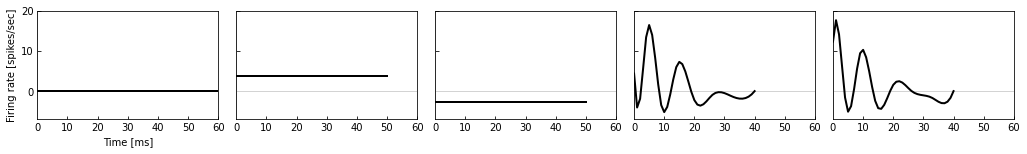

util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_kernel100ms_11252021_2242/group_model_pars_joint_itr24_20211126_145616.pkl


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   33.8s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  3.0min
[Parallel(n_jobs=12)]: Done 285 out of 285 | elapsed:  4.9min finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   36.2s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  3.3min
[Parallel(n_jobs=12)]: Done 285 out of 285 | elapsed:  5.4min finished


filter_membership.shape (672, 285)
membership cnt [(0.0, 44160), (3.0, 29117), (2.0, 49705), (1.0, 39305), (4.0, 29233)]
filter_membership.shape (648, 285)
membership cnt [(0.0, 33774), (3.0, 31199), (2.0, 51075), (1.0, 36593), (4.0, 32039)]
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_kernel100ms_11252021_2242/filter_membership_CD_itr25_20211126_150636.pkl
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_kernel100ms_11252021_2242/filter_membership_DE_itr25_20211126_150636.pkl
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_kernel100ms_11252021_2242/group_portion_itr25_20211126_150636.pkl
filter_membership.shape (1320, 285)
#all trials:75898	#batch trials:75898
X.shape (1352120, 3), basis_

/home/yuchen/workspace/Brain_Network/Code/jitter.py:4090: UserWarning: Reach max itrs 60. Last err:2.647e-02
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


#all trials:61272	#batch trials:61272
X.shape (1394811, 11), basis_integral.shape (11, 1),beta.shape(11, 1)
100%|███████████████████████████████████████████████████████████████| 60/60 [00:11<00:00,  5.27it/s]
num itr 59 [[-2345440.06004498]] 0.025513190420853548
beta [ 13.71044775   0.0292395   12.19274686  28.46218584 -25.61802406  24.67836674 -13.29638722   6.56586534
  -1.83458337  -0.22922259  -4.97200112]
gradient [-1.14777734e+00  3.87228194e+01 -2.38182057e+00 -2.59820022e+00 -5.70065852e-01 -2.41076087e+00
  1.33359515e-02  6.98783090e-02  2.47363432e-01  1.19959823e+00  1.19148266e+00]
Finish 4.


/home/yuchen/workspace/Brain_Network/Code/jitter.py:4090: UserWarning: Reach max itrs 60. Last err:2.551e-02
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


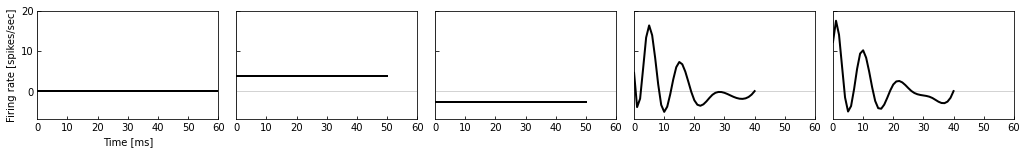

util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_kernel100ms_11252021_2242/group_model_pars_joint_itr25_20211126_152316.pkl


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   33.9s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  3.0min
[Parallel(n_jobs=12)]: Done 285 out of 285 | elapsed:  5.0min finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   36.6s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  3.4min
[Parallel(n_jobs=12)]: Done 285 out of 285 | elapsed:  5.5min finished


filter_membership.shape (672, 285)
membership cnt [(0.0, 44432), (3.0, 28958), (2.0, 49844), (1.0, 39235), (4.0, 29051)]
filter_membership.shape (648, 285)
membership cnt [(0.0, 34044), (3.0, 31087), (2.0, 51086), (1.0, 36514), (4.0, 31949)]
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_kernel100ms_11252021_2242/filter_membership_CD_itr26_20211126_153342.pkl
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_kernel100ms_11252021_2242/filter_membership_DE_itr26_20211126_153342.pkl
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_kernel100ms_11252021_2242/group_portion_itr26_20211126_153342.pkl
filter_membership.shape (1320, 285)
#all trials:75749	#batch trials:75749
X.shape (1351168, 3), basis_

/home/yuchen/workspace/Brain_Network/Code/jitter.py:4090: UserWarning: Reach max itrs 60. Last err:2.234e-02
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


#all trials:61000	#batch trials:61000
X.shape (1389712, 11), basis_integral.shape (11, 1),beta.shape(11, 1)
100%|███████████████████████████████████████████████████████████████| 60/60 [00:11<00:00,  5.30it/s]
num itr 59 [[-2338072.56366996]] 0.02577037586987319
beta [ 13.71979129   0.03022151  12.16612487  28.54795206 -25.70916285  24.7883796  -13.47685142   6.76648177
  -1.9143266   -0.22942679  -4.95691229]
gradient [-1.08173885 39.05151064 -2.373609   -2.58550683 -0.54808387 -2.38583992  0.07254648  0.0802244   0.27018479
  1.22673833  1.20342418]
Finish 4.


/home/yuchen/workspace/Brain_Network/Code/jitter.py:4090: UserWarning: Reach max itrs 60. Last err:2.577e-02
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


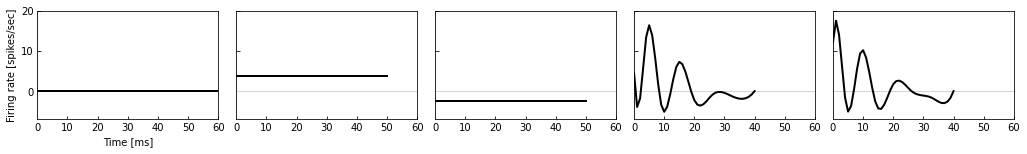

util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_kernel100ms_11252021_2242/group_model_pars_joint_itr26_20211126_155023.pkl


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   34.1s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  3.0min
[Parallel(n_jobs=12)]: Done 285 out of 285 | elapsed:  5.0min finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   36.6s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  3.4min
[Parallel(n_jobs=12)]: Done 285 out of 285 | elapsed:  5.5min finished


filter_membership.shape (672, 285)
membership cnt [(0.0, 44118), (3.0, 29165), (2.0, 49590), (1.0, 39244), (4.0, 29403)]
filter_membership.shape (648, 285)
membership cnt [(0.0, 33637), (3.0, 31246), (2.0, 51047), (1.0, 36630), (4.0, 32120)]
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_kernel100ms_11252021_2242/filter_membership_CD_itr27_20211126_160050.pkl
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_kernel100ms_11252021_2242/filter_membership_DE_itr27_20211126_160050.pkl
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_kernel100ms_11252021_2242/group_portion_itr27_20211126_160050.pkl
filter_membership.shape (1320, 285)
#all trials:75874	#batch trials:75874
X.shape (1351293, 3), basis_

/home/yuchen/workspace/Brain_Network/Code/jitter.py:4090: UserWarning: Reach max itrs 60. Last err:2.219e-02
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


#all trials:61523	#batch trials:61523
X.shape (1398269, 11), basis_integral.shape (11, 1),beta.shape(11, 1)
100%|███████████████████████████████████████████████████████████████| 60/60 [00:12<00:00,  4.62it/s]
num itr 59 [[-2349069.42763625]] 0.025580472934306098
beta [ 13.69142227   0.03077719  12.08152336  28.45357696 -25.66434207  24.74098245 -13.5699602    6.91655586
  -1.99641266  -0.21640925  -4.94659589]
gradient [-1.11175563e+00  3.84287594e+01 -2.38320041e+00 -2.59765847e+00 -5.57630943e-01 -2.39438615e+00
  6.25579018e-02  3.48497906e-02  2.59760122e-01  1.23295627e+00  1.20397436e+00]
Finish 4.


/home/yuchen/workspace/Brain_Network/Code/jitter.py:4090: UserWarning: Reach max itrs 60. Last err:2.558e-02
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


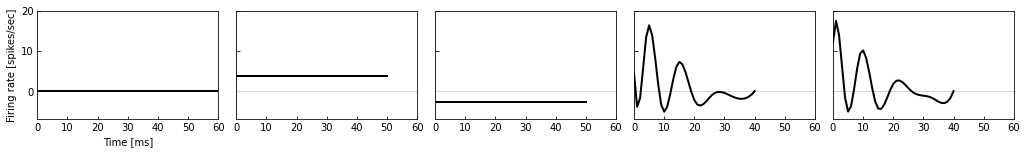

util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_kernel100ms_11252021_2242/group_model_pars_joint_itr27_20211126_161726.pkl


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   44.9s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  3.3min
[Parallel(n_jobs=12)]: Done 285 out of 285 | elapsed:  5.3min finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   38.9s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  3.5min
[Parallel(n_jobs=12)]: Done 285 out of 285 | elapsed:  5.6min finished


filter_membership.shape (672, 285)
membership cnt [(0.0, 44429), (3.0, 28819), (2.0, 49981), (1.0, 39078), (4.0, 29213)]
filter_membership.shape (648, 285)
membership cnt [(0.0, 34087), (3.0, 31083), (2.0, 51121), (1.0, 36446), (4.0, 31943)]
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_kernel100ms_11252021_2242/filter_membership_CD_itr28_20211126_162817.pkl
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_kernel100ms_11252021_2242/filter_membership_DE_itr28_20211126_162817.pkl
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_kernel100ms_11252021_2242/group_portion_itr28_20211126_162817.pkl
filter_membership.shape (1320, 285)
#all trials:75524	#batch trials:75524
X.shape (1350006, 3), basis_

/home/yuchen/workspace/Brain_Network/Code/jitter.py:4090: UserWarning: Reach max itrs 60. Last err:2.906e-02
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


#all trials:61156	#batch trials:61156
X.shape (1391017, 11), basis_integral.shape (11, 1),beta.shape(11, 1)
100%|███████████████████████████████████████████████████████████████| 60/60 [00:11<00:00,  5.23it/s]
num itr 59 [[-2337960.47396997]] 0.025552619766677328
beta [ 13.70003994   0.03020872  12.03775871  28.4144785  -25.70243642  24.78969179 -13.68822578   7.11423733
  -2.07900305  -0.19554014  -4.93462926]
gradient [-1.09291140e+00  3.98792011e+01 -2.36467034e+00 -2.57056244e+00 -5.35651494e-01 -2.36582570e+00
  9.08539304e-02  2.17005706e-02  2.72163546e-01  1.24816899e+00  1.20549986e+00]
Finish 4.


/home/yuchen/workspace/Brain_Network/Code/jitter.py:4090: UserWarning: Reach max itrs 60. Last err:2.555e-02
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


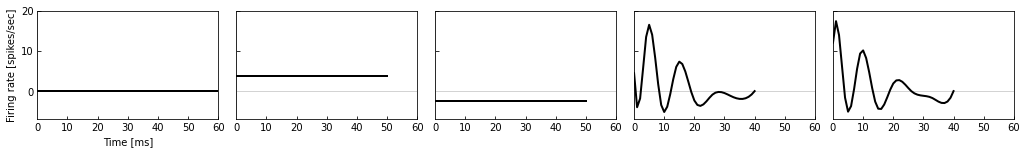

util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_kernel100ms_11252021_2242/group_model_pars_joint_itr28_20211126_164445.pkl


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   33.4s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  3.0min
[Parallel(n_jobs=12)]: Done 285 out of 285 | elapsed:  5.0min finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   36.6s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  3.4min
[Parallel(n_jobs=12)]: Done 285 out of 285 | elapsed:  5.4min finished


filter_membership.shape (672, 285)
membership cnt [(0.0, 43740), (3.0, 29341), (2.0, 49809), (1.0, 39097), (4.0, 29533)]
filter_membership.shape (648, 285)
membership cnt [(0.0, 33278), (3.0, 31422), (2.0, 51127), (1.0, 36463), (4.0, 32390)]
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_kernel100ms_11252021_2242/filter_membership_CD_itr29_20211126_165508.pkl
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_kernel100ms_11252021_2242/filter_membership_DE_itr29_20211126_165508.pkl
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_kernel100ms_11252021_2242/group_portion_itr29_20211126_165508.pkl
filter_membership.shape (1320, 285)
#all trials:75560	#batch trials:75560
X.shape (1348877, 3), basis_

/home/yuchen/workspace/Brain_Network/Code/jitter.py:4090: UserWarning: Reach max itrs 60. Last err:2.629e-02
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


#all trials:61923	#batch trials:61923
X.shape (1408512, 11), basis_integral.shape (11, 1),beta.shape(11, 1)
100%|███████████████████████████████████████████████████████████████| 60/60 [00:11<00:00,  5.13it/s]
num itr 59 [[-2367274.20353988]] 0.025503203707778775
beta [ 13.7075497    0.03132241  11.97715587  28.39090945 -25.74958397  24.79627609 -13.80560101   7.26667378
  -2.15321646  -0.19384515  -4.93616691]
gradient [-1.08751552e+00  3.96283930e+01 -2.37917215e+00 -2.58313899e+00 -5.28022673e-01 -2.37230086e+00
  1.05915434e-01  6.56802545e-04  2.80494259e-01  1.27361768e+00  1.22032543e+00]
Finish 4.


/home/yuchen/workspace/Brain_Network/Code/jitter.py:4090: UserWarning: Reach max itrs 60. Last err:2.550e-02
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


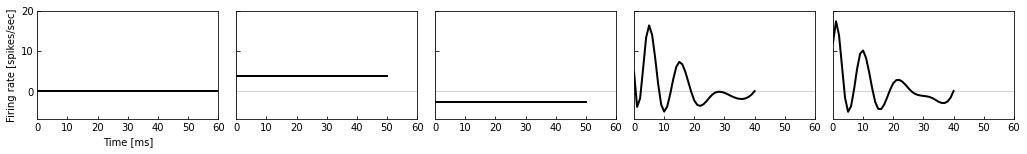

util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_kernel100ms_11252021_2242/group_model_pars_joint_itr29_20211126_171155.pkl


In [46]:
output_dir = project_dir + f'Output/jitter/coupling_filter/CD_DE_condition21_joint_fit_fixed_portion_kernel60ms_11262021_2255/'

for itr in range(0, 30):
    jobs_CD, jobs_DE = [], []
    for trial_id in selected_trial_ids:
        job1 = delayed(model.update_filter_membership)(spike_times, trial_window, group_portion, group_model_pars, 
                                                       filter_membership_CD, [trial_id], parallel=True)
        job2 = delayed(model.update_filter_membership)(spike_times, trial_window, group_portion, group_model_pars, 
                                                       filter_membership_DE, [trial_id], parallel=True)
        jobs_CD.append(job1)
        jobs_DE.append(job2)
    with Parallel(n_jobs=num_paral_jobs, verbose=1) as parallel_pool:
        jobs_CD_out = parallel_pool(jobs_CD)
        jobs_DE_out = parallel_pool(jobs_DE)
    filter_membership_CD = pd.concat(jobs_CD_out, axis=1)
    filter_membership_DE = pd.concat(jobs_DE_out, axis=1)
    model.filter_membership_statistics(filter_membership_CD)
    model.filter_membership_statistics(filter_membership_DE)
    file_path = output_dir + f'filter_membership_CD_itr{itr}_{time.strftime("%Y%m%d_%H%M%S")}.pkl'
    util.save_variable(file_path, filter_membership_CD)
    file_path = output_dir + f'filter_membership_DE_itr{itr}_{time.strftime("%Y%m%d_%H%M%S")}.pkl'
    util.save_variable(file_path, filter_membership_DE)

    filter_membership_joint = filter_membership_CD.append(filter_membership_DE)

#     group_portion = model.update_membership_portion(5, filter_membership_joint)
    file_path = output_dir + f'group_portion_itr{itr}_{time.strftime("%Y%m%d_%H%M%S")}.pkl'
    util.save_variable(file_path, group_portion)

    group_model_pars = model.update_cluster_filter_joint_trail(filter_membership_joint, verbose=True)
    model.plot_multiple_filters(group_model_pars, ylim=[-7, 20], num_rows_cols=[1,5])
    file_path = output_dir + f'group_model_pars_joint_itr{itr}_{time.strftime("%Y%m%d_%H%M%S")}.pkl'
    util.save_variable(file_path, group_model_pars)